This notebook compares the computational cost of WENO and CTCS schemes whilst modelling the advection equation with discontinuous initial conditions, given a CFL conditions, these schemes are utilised to model the equation over a given distance and velocity and spatial discretisations are found such that the achieve the same average deviation from the analytic solution. The results of this comparison are plotted below.  

In [1]:
using Plots
using LinearAlgebra
using BenchmarkTools

In [2]:
function error(numerical, analytic)
    return mean(abs.(analytic - numerical)) 
end

error (generic function with 1 method)

In [3]:
# For the first time step using the centred time scheme
function ftbs_matrix(n, dx, dt, a)
    r = a*dt/dx
    d = (1-r)*ones(n)
    dl = r*ones(n-1)
    du = zeros(n-1)
    return Tridiagonal(dl, d, du)
end

ftbs_matrix (generic function with 1 method)

Analytic solution to either continuous or discontinuous initial conditions

In [4]:
c_analytic(x, distance, σ²) = @. exp(-(x+0.5-distance)^2/(2*σ²))
function c_analytic(x, distance)
    c_ana = zeros(length(x))
    c_ana[abs.(x.+0.5.-distance) .<= 0.25] .= 1
    return c_ana
end

c_analytic (generic function with 2 methods)

In [5]:
function set_initial_conditions(n, L, U, distance, CFL)
    dx = 2*L/(n-1)
    dt = CFL*dx/U
    x = collect(-L:dx:L)
    c0 = zeros(n)
    c0[abs.(x.+0.5) .<= 0.25] .= 1
    c = zeros(n)
    c .= c0
    ftbs = ftbs_matrix(n, dx, dt, U)
    time_steps = distance / dt
    cprime = zeros(n)
    u = zeros(n)
    return dx, dt, x, c, c0, ftbs, time_steps, cprime, u
end

set_initial_conditions (generic function with 1 method)

### CTCS Methods

In [6]:
function centred_difference!(fprime, f, dx, n)
    for i in 2:(n-1)
        fprime[i] = (f[i+1]-f[i-1])/(2*dx)
    end
    fprime[1] = (f[2]-f[1])/dx
    fprime[n] = (f[n]-f[n-1])/dx
    return nothing
end

function next_step_ctcs!(c, cprevious, ctemp, r)
    ctemp .= c
    c[1] = - r*ctemp[2]
    c[end] = + r*ctemp[end-1]
    for i in range(2, length(c)-1, step = 1)
        c[i] = r*ctemp[i-1] - r*ctemp[i+1]
    end
    c .+= cprevious
    cprevious .= ctemp
    return nothing
end

function step_forward_n_ctcs(c0, time_steps, U, dt, dx, ftbs)
    c = zeros(length(c0))
    cprevious = zeros(length(c0))
    ctemp = zeros(length(c0))
    cprevious .= c0
    c .= ftbs*cprevious
    r = U*dt/dx
    for j = 1:time_steps
        next_step_ctcs!(c, cprevious, ctemp, r)
    end
    return c
end

step_forward_n_ctcs (generic function with 1 method)

### WENO Methods

In [7]:
@inline u1(c, i) = @inbounds 1/3*c[i-2] - 7/6*c[i-1] + 11/6*c[i]
@inline u2(c, i) = @inbounds -1/6*c[i-1] + 5/6*c[i] + 1/3*c[i+1]
@inline u3(c, i) = @inbounds 1/3*c[i] + 5/6*c[i+1] - 1/6*c[i+2]

@inline β1(c, i) = @inbounds 13/12*(c[i-2] - 2*c[i-1] + c[i])^2 + 1/4*(c[i-2] - 4*c[i-1] + 3*c[i])^2
@inline β2(c, i) = @inbounds 13/12*(c[i-1] - 2*c[i] + c[i+1])^2 + 1/4*(c[i-1] - c[i+1])^2
@inline β3(c, i) = @inbounds 13/12*(c[i] - 2*c[i+1] + c[i+2])^2 + 1/4*(3*c[i] - 4*c[i+1] + c[i+2])^2

const γ1 = 1/10
const γ2 = 3/5
const γ3 = 3/10
const ϵ = 1e-6

@inline wbar1(c, i) = @inbounds γ1/(ϵ + β1(c, i))^2
@inline wbar2(c, i) = @inbounds γ2/(ϵ + β2(c, i))^2
@inline wbar3(c, i) = @inbounds γ3/(ϵ + β3(c, i))^2

@inline w1(c, i) = @inbounds wbar1(c, i)/(wbar1(c, i) + wbar2(c, i) + wbar3(c, i))
@inline w2(c, i) = @inbounds wbar2(c, i)/(wbar1(c, i) + wbar2(c, i) + wbar3(c, i))
@inline w3(c, i) = @inbounds wbar3(c, i)/(wbar1(c, i) + wbar2(c, i) + wbar3(c, i))

@inline weno_interpolant(c, i) = @inbounds w1(c, i)*u1(c, i)+w2(c, i)*u2(c, i)+w3(c, i)*u3(c, i)

function weno_derivative!(cprime, c, delta, u, n)
    for i = 3:n-3
        u[i] = weno_interpolant(c, i)
    end
    
    for i = 3:n-4
        @inbounds cprime[i+1] = (u[i+1]-u[i])/delta
    end
    for i in 1:3
        @inbounds cprime[i] = 0
        @inbounds cprime[end - i+ 1] = 0
    end
    return nothing
end

function next_step!(c, dx, dt, U, u, cprime, n)
    weno_derivative!(cprime, c, dx, u, n)
    @. c -= U*dt*cprime
    return nothing
end

function step_forward_n_weno!(c, dx, dt, U, time_steps, u, cprime)
    for i in 1:time_steps
        next_step!(c, dx, dt, U, u, cprime, length(c))
    end
    return nothing
    δ
end

step_forward_n_weno! (generic function with 1 method)

The calculation of the derivative is the and the component that varies between the two implementations and also the most computationally expensive component of progressing one time step. Therefore, the computational expense of calculating the derivative using each scheme was determined. It was assumed that the expense scales linearly with n and hence knowing the expense for some n and also the number of times the calculation of the derivative was required to achieve a given accuracy (based on the magnitude of the δt), we can compare the schemes computationally complexity. The implementation of this strategy follows. 

In [8]:
#Inital Conditions
n = 101
L = 1
U = 1
distance = 0.9
CFL = 0.1;

Benchmarking the WENO and CD derivative calculations

In [9]:
dx, dt, x, c, c0, ftbs, time_steps, cprime, u = set_initial_conditions(n, L, U, distance, CFL)
@btime weno_derivative!(cprime, c0, dx, u, n)

  2.311 μs (0 allocations: 0 bytes)


In [10]:
dx, dt, x, c, c0, ftbs, time_steps, cprime, u = set_initial_conditions(n, L, U, distance, CFL)
@btime centred_difference!(cprime, c0, dx, n)

  203.200 ns (0 allocations: 0 bytes)


Evaulting the spatial discretisation required to achieve a given error (generated from a range of disritaistions of the WENO scheme) with the CTCS scheme given a CFL condition of 0.1. This cell has a lot to evaulate so runs for a long time.

In [11]:
c = []
x = []
c_C = []
x_C = []
errors = []
nsC = []
nsW = 50:20:190
prev_n = 1400
for n in nsW 
    dx, dt, x, c, c0, ftbs, time_steps, cprime, u = set_initial_conditions(n, L, U, distance, CFL)
    step_forward_n_weno!(c, dx, dt, U, time_steps, u, cprime)
    analytic = c_analytic(x, distance)
    errorW = error(c, analytic)
    push!(errors, errorW)
    for nC in prev_n:100:26000
        dx, dt, x_C, c_C, c0, ftbs, time_steps, cprime, u = set_initial_conditions(nC, L, U, distance, CFL)
        c_C = step_forward_n_ctcs(c0, time_steps, U, dt, dx, ftbs)
        analytic = c_analytic(x_C, distance)
        errorC = error(c_C, analytic)
        if (errorC < errorW)
            push!(nsC, nC)
            prev_n = nC
            break
        end
    end
end

The final (most accurate) approximation of the WENO and CTCS schemes analysed. 

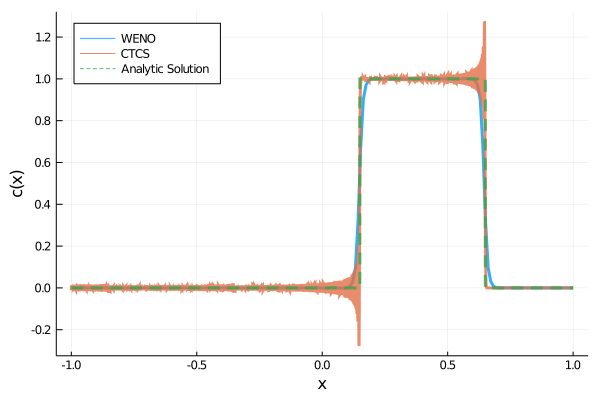

In [12]:
analytic = c_analytic(x_C, distance)
plot(x, c, label = "WENO", legend=:topleft, lw=3, alpha=0.8)
plot!(x_C, [c_C, analytic], label = ["CTCS" "Analytic Solution"], legend=:topleft, linestyle=[:solid :dash], lw=3, alpha=0.8,
    xlabel = "x", ylabel = "c(x)")

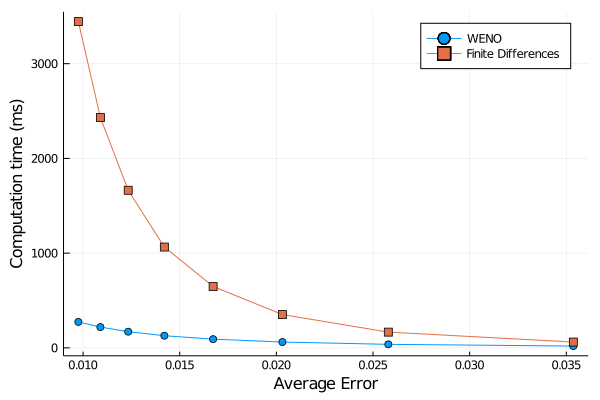

In [13]:
# Scales the n to approximate timing
timeW = @. nsW*9.91720289*nsW*0.000765023037
timeC = @. nsC*nsW*0.000765023037
plot(errors, [timeW, timeC], label = ["WENO" "Finite Differences"], m=:auto, 
    xlabel = "Average Error", ylabel = "Computation time (ms)")

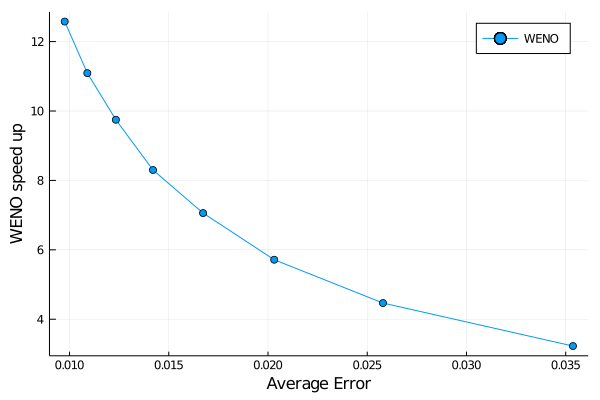

In [17]:
# Scales the n to approximate timing
ratio = timeC./timeW
plot(errors, ratio, label = ["WENO" "Finite Differences"], m=:auto, 
    xlabel = "Average Error", ylabel = "WENO speed up")